# Desafio 7 - Modelo de análise das métricas RFM #

## Apresentação do problema ##

Uma empresa de e-commerce está buscando entender
melhor o comportamento de seus clientes para personalizar as suas campanhas de
marketing.

Para isso, a empresa disponibilizou uma base de dados em csv contendo
dados sobre clientes, produtos e transações da loja realizadas entre os anos de 2010 e
2011.
Com base nesses dados, vamos agrupar os clientes em clusters com base em
seu comportamento de compra. Isso irá permitir identificar padrões e características em
comum entre os clientes, como:

*   Clientes que compram os mesmos produtos;
*   Clientes que possuem a mesma frequência de compras;
*   Clientes que gastam mais dinheiro em suas compras.

A partir desses clusters, gerar insights para que a empresa possa segmentar melhor a
sua base de clientes e personalizar as suas campanhas de marketing, direcionando
promoções e ofertas aos clientes com base no comportamento de compras.


## Sobre os dados ##

Os dados fornecidos possuem informações de transações de compras de uma loja de
e-commerce em 38 países e territórios, com mais de 4.000 clientes únicos e mais de
540.000 transações.


## 0 - Importando as bibliotecas ##

In [14]:
%%capture
%pip install kmodes

In [123]:
# Data wrangling
import numpy as np
import pandas as pd
from datetime import date

# Dataviz
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance, kelbow_visualizer, silhouette_visualizer

## -- Machine learning -- ##
from sklearn.cluster import KMeans
from sklearn.cluster import k_means
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import scale

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

from kmodes.kmodes import KModes            # clustering categorical data
from kmodes.kprototypes import KPrototypes  # clustering mixed data

# Didatic purposes
import string
from ipywidgets import interact

In [16]:
# Configuração da tela de plot
sns.set_theme(
    context='talk',
    style='ticks',
    font_scale=.8,
    palette='tab10',
    rc={
        'figure.figsize': (12,8),
        'axes.grid': True,
        'grid.alpha': .2,
        'axes.titlesize': 'x-large',
        'axes.titleweight': 'bold',
        'axes.titlepad': 20,
    }
)

scatter_kwargs = dict(palette='viridis', alpha=0.8, linewidth=0)

## 1 - Leitura e Inspeção de dados ##

In [141]:
# Carregando os dados
dados = pd.read_csv('/content/data.csv', sep = ',',  encoding= 'unicode_escape')

In [3]:
display(dados)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


In [115]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392692 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    392692 non-null  object 
 1   StockCode    392692 non-null  object 
 2   Description  392692 non-null  object 
 3   Quantity     392692 non-null  int64  
 4   InvoiceDate  392692 non-null  object 
 5   UnitPrice    392692 non-null  float64
 6   CustomerID   392692 non-null  int64  
 7   Country      392692 non-null  object 
 8   Total        392692 non-null  float64
dtypes: float64(2), int64(2), object(5)
memory usage: 30.0+ MB


In [7]:
dados.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [8]:
dados.isna().sum().sort_values(ascending = False)

CustomerID     135080
Description      1454
InvoiceNo           0
StockCode           0
Quantity            0
InvoiceDate         0
UnitPrice           0
Country             0
dtype: int64

In [18]:
dados[dados.duplicated()].shape

(5268, 8)



*   Nossa base de dados possui 541909 kinhas × 8 colunas, 5268 linhas duplicadas , dados nulos nas colunas CustomerID e Description



## 2 - Pré-processamento dos dados ##

In [142]:
# Eliminando as linhas faltantes
# Como a maior parte das linhas faltantes se tratam dos clientes, os dados dessas compras não teram utilidade para nosso modelo
dados = dados.dropna()

In [143]:
# Criando uma variavel para filtrar apenas dados categoricos do DF
# Esse metodo está selecionando os tipos que nao são numeros
categorical_columns = dados.select_dtypes(exclude='number')
dados_scaled = dados.select_dtypes(exclude='object')

In [144]:
# Limpeza de Outliers
outlier_rows = dados_scaled.abs().gt(3).any(axis=1)
outlier_rows.sum()
dados_scaled = dados_scaled[~outlier_rows]

(array([1, 2]), [Text(1, 0, 'Quantity'), Text(2, 0, 'UnitPrice')])

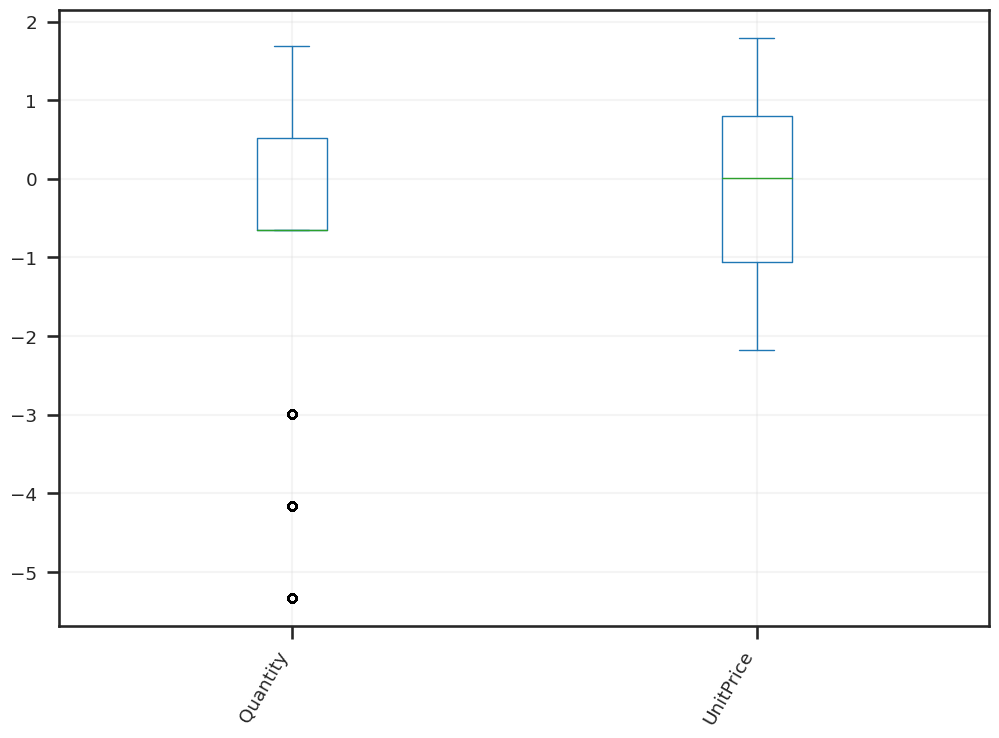

In [89]:
#Plotando nosso boxplot
dados_scaled = dados_scaled.apply(scale)
dados_scaled.plot.box()
plt.xticks(rotation=60, ha='right')

In [ ]:
# Verificando dados onde o Preço e a quantidade são menores que 0
dados.query('UnitPrice <= 0')

In [ ]:
dados.query('Quantity <= 0')

In [145]:
# Eliminando valores de Preço e quantidade menor que 0
dados = dados.query('UnitPrice > 0 & Quantity > 0')

In [146]:
# Removendo linhas duplicadas
duplicadas = dados[dados.duplicated() == True]
dados = dados.drop(duplicadas.index, axis = 0)
dados[dados.duplicated() == True].shape

(0, 8)

In [163]:
# Conversão das colunas
dados['CustomerID'] = dados['CustomerID'].astype(int)
dados['InvoiceDate'] = pd.to_datetime(dados['InvoiceDate'], format='%m/%d/%Y %H:%M')

In [147]:
# Criando a Feature da nossa base para fazer o RFM
dados['Total'] = dados['Quantity'] * dados['UnitPrice']
dados.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34


In [166]:
# Data da ultima compra para calculo
ultima_compra = dados['InvoiceDate'].max() + dt.timedelta(days=1)
ultima_compra

Timestamp('2011-12-10 12:50:00')

In [167]:
# Crição da tabela RFM dos nossos clientes
rfm = dados.groupby(['CustomerID']).agg({'InvoiceDate': lambda x : (ultima_compra - x.max()).days, 'InvoiceNo':'count','Total': 'mean'})
# Renomeando as colunas, pois elas são criadas com os nomes originais e não das métricas
rfm = rfm.rename(columns={'InvoiceDate':'Recência','InvoiceNo':'Frequência','Total':'ValorMonetario'})

In [169]:
rfm.head()

,Recência,Frequência,ValorMonetario
CustomerID,,,
12346,326,1,77183.600000
12347,2,182,23.681319
12348,75,31,57.975484
12349,19,73,24.076027
12350,310,17,19.670588


Iremos utilizar as metricas de RFM para criação dos clusters pois essa metrica ajuda a ver com mais clareza o comportamento dos nossos clientes ao longo do nosso periodo analisado

## 3 - Algoritmo de cluesterização KMeans ##

A razão da escolha do algoritmo de KMeans é por conta dos tipos e similaridade dos dados que estamos trabalhando

O Kmeans é excelente para a nossa grande quantidade de dados, para definição de quantos grupos queremos de acordo com o nosso calculo que será feito. Com base nos dados que temos, vamos trabalhar com dados numéricos que estão na mesma escala, então Kmenas é a escolha correta.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

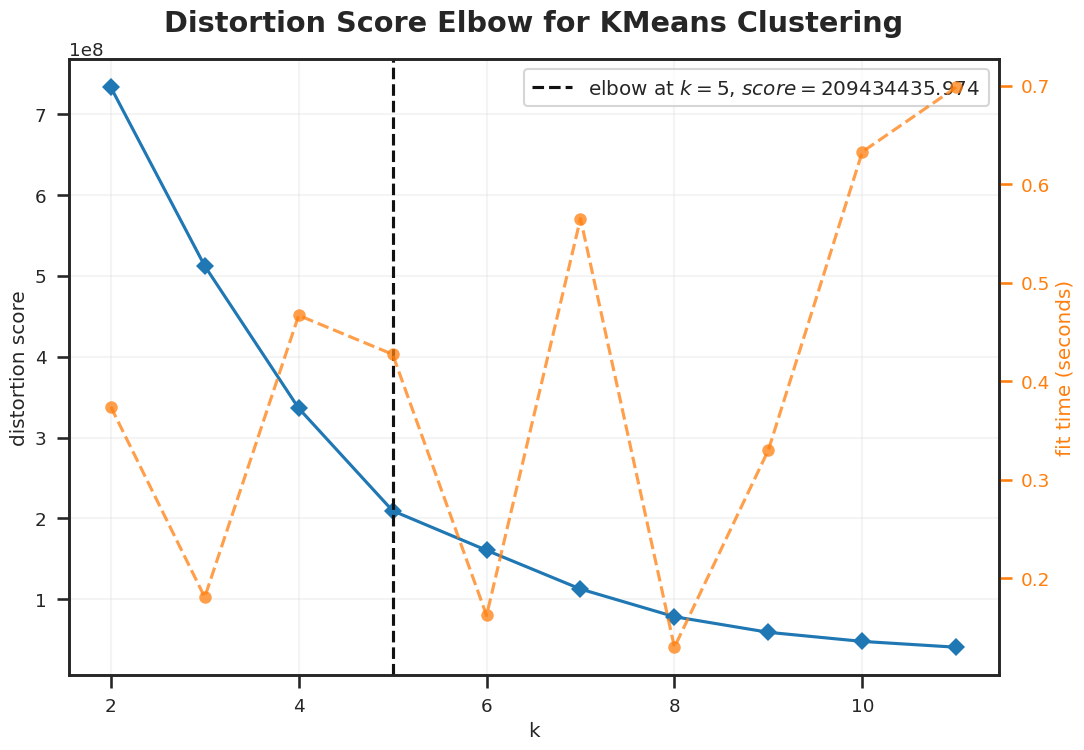

In [170]:
# Escolhendo o melhor K
kelbow_visualizer(KMeans(), rfm, k=11);



*   O nosso melhor K de acordo com a analise é 6



In [171]:
#Criando e treinando o modelo
model = KMeans(6, random_state=0).fit(rfm)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [172]:
# Centroids e labels
centroids = model.cluster_centers_
labels = model.labels_

## 4 - Analise dos Clusters ##

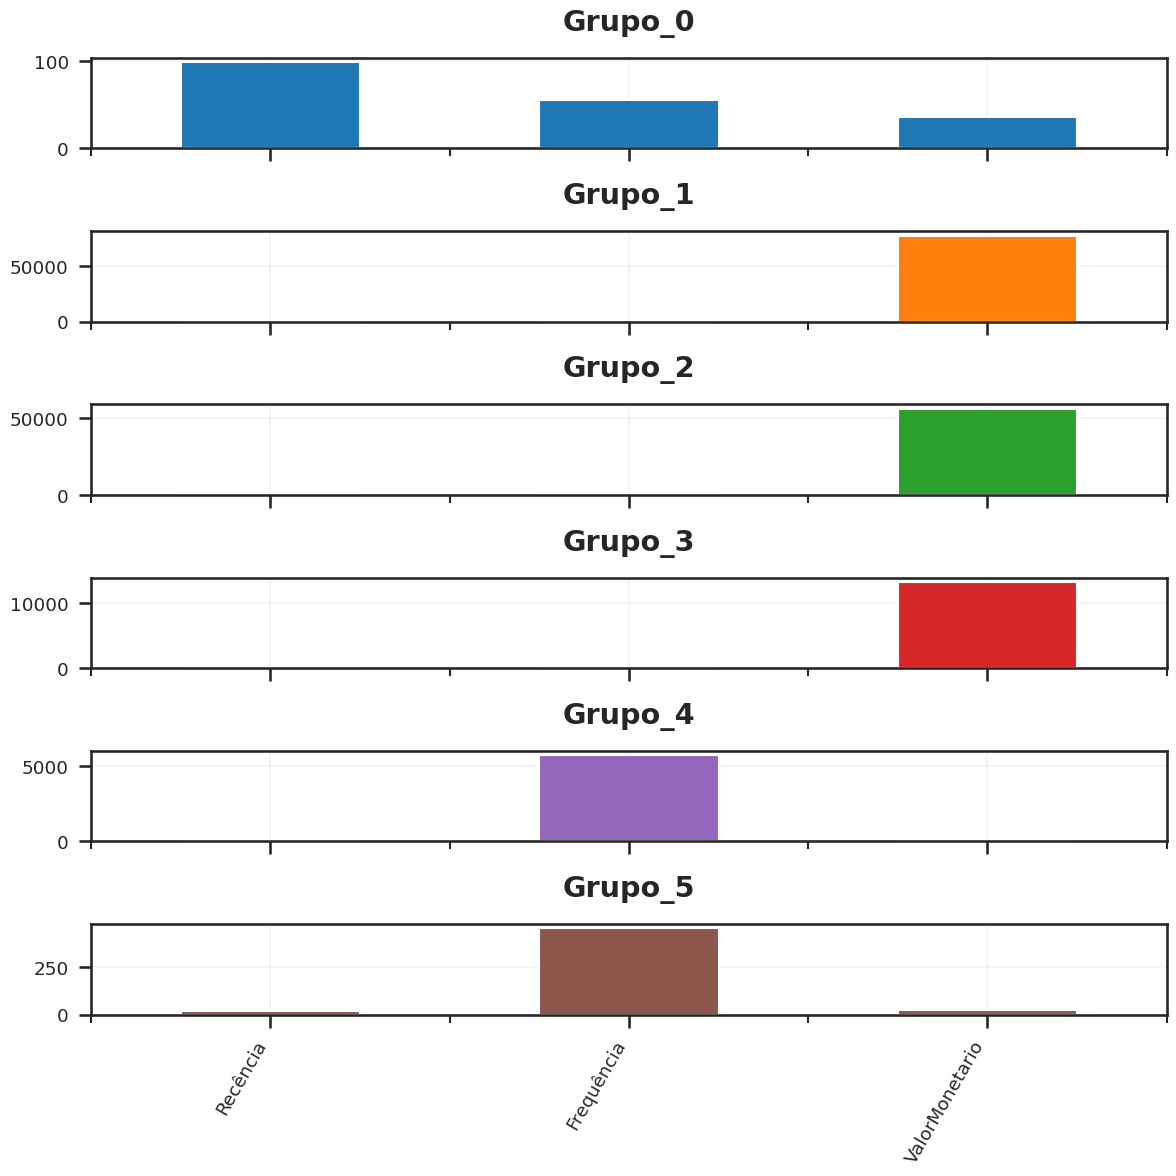

In [173]:
# Visualizando os clusters

(
  pd.DataFrame(centroids, columns=rfm.columns)
  .T.add_prefix('Grupo_')
  .plot.bar(subplots=True, figsize=(12,12), legend=False)
)

plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()



*   Com esse gráfico já conseguimos notar tendencias nos nossos clientes principalmente em relação a Valor Monetario e Frequencia



In [174]:
centers = pd.DataFrame(centroids, columns=rfm.columns)
centers

,Recência,Frequência,ValorMonetario
0,98.734898,55.772092,35.617434
1,326.000000,1.000000,77183.600000
2,1.000000,3.000000,56157.500000
3,182.000000,3.000000,13305.500000
4,2.000000,5717.250000,12.716556
5,16.535385,450.440000,22.333626


In [176]:
(
  rfm.assign(cluster=labels)
  .groupby('cluster')
  .agg(['mean','min','median','max'])
)

Recência                    Frequência                      \
               mean  min median  max         mean   min  median   max   
cluster                                                                 
0         98.734898    1   58.0  374    55.772092     1    35.0   297   
1        326.000000  326  326.0  326     1.000000     1     1.0     1   
2          1.000000    1    1.0    1     3.000000     3     3.0     3   
3        182.000000  182  182.0  182     3.000000     3     3.0     3   
4          2.000000    1    1.5    4  5717.250000  4412  5390.5  7676   
5         16.535385    1   10.0  156   450.440000   245   354.0  2677   

        ValorMonetario                                            
                  mean           min        median           max  
cluster                                                           
0            35.617434      2.136970     17.950154   4453.430000  
1         77183.600000  77183.600000  77183.600000  77183.600000  
2         56157.500000  56157.500000  56157.500000  56157.500000  
3         13305.500000  13305.500000  13305.500000  13305.500000  
4            12.716556      5.278770     10.120783     25.345885  
5            22.333626      2.563947     12.259795    602.453132

In [177]:
(
  rfm.assign(cluster=labels)
  .groupby('cluster')
  .mean()
  .transpose()
  .style.background_gradient(cmap='YlOrRd', axis=1)
)

cluster,0,1,2,3,4,5
Recência,98.734898,326.000000,1.000000,182.000000,2.000000,16.535385
Frequência,55.772092,1.000000,3.000000,3.000000,5717.250000,450.440000
ValorMonetario,35.617434,77183.600000,56157.500000,13305.500000,12.716556,22.333626


In [178]:
silhouette_score(rfm, labels)

0.6103873973185919

Identificamos padrões importantes no nosso cluster de Kmeans, percebemos grupos distintos com caracteristicas que podem apresentar oportunidades de oferecer propostas e ofertas

## 5 - Conclusão ##

Após a contrução do cluster, identificamos grupos de clientes com comportamentos interessantes

*   Grupo 0 - São os Cliente que compraram nos ultimos dias e tem uma frequencia regular de compra com valor moderado
*   Grupo 1 - Clientes que não compram com frequencia mas recentemente gastaram bastante
*   Grupo 2 - Clientes que fizeram compras grandes a bastante tempo com  frequencia baixa
*   Grupo 3 - Clientes que recentemente fizeram compra grande mas com baixa periodicidade
*   Grupo 4 - Clientes que compram com muita frequencia produtos baratos
*   Grupo 5 - Clientes que Compram com frequencia recentemente e gastaram moderadamente  



-> Para os Grupos 0, 4 e 5 seria interessante apresentar programas de ofertas para compras periodicas

-> Para os Grupos 1, 2 e 3 a melhor forma de capta-los seriam ofertas de temporada, como por exemplo epocas festivas e periodos comuns de ferias